## Overview

### External Interface Requirements
1. Input requirement: capacity to read a dataset stored on disk.
2. Output requirement: report on optimal number of clusters, centroid coordinates and quality metric.
3. Output requirement: identifiers of classes corresponding to new instances classified by the model.

### Functional Requirements
1. The software must learn a clusterization a the dataset.
2. The software must use the learned clusterization to classify new problem instances.
3. The software must evaluate the quality of a clusterization.
4. The software must be flexible to work with different preconfigured amount of clusters.
5. The software must compare results using different numbers of clusters and determine which number of clusters is best.


### Necessary Deliverables
1. Python application that performs ETL, training, and testing.
2. Report containing quality metrics, and explanation of the dataset, and the experimental procedure (range of the different number of clusters that were tested, how the range was traversed, etc.).

### Further notes
	- Find data & understand it (sometimes need to aggregate rows of data as each line is not unique) 
    - Perform data cleaning&feature engineering 
	- First find all different clusters (types) of clients/products 
	- 2nd find their characteristics 

In [94]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [95]:
taxi = pd.read_csv('../data/train.csv')

### Exploring the data & variables

In [96]:
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [97]:
taxi.shape

(1458644, 11)

In [98]:
taxi.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [99]:
taxi.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [100]:
missing = taxi.isnull().sum()
missing

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

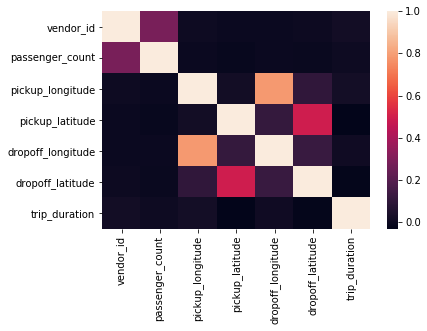

In [101]:
sns.heatmap(taxi.corr())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22641d68>,
      dtype=object)

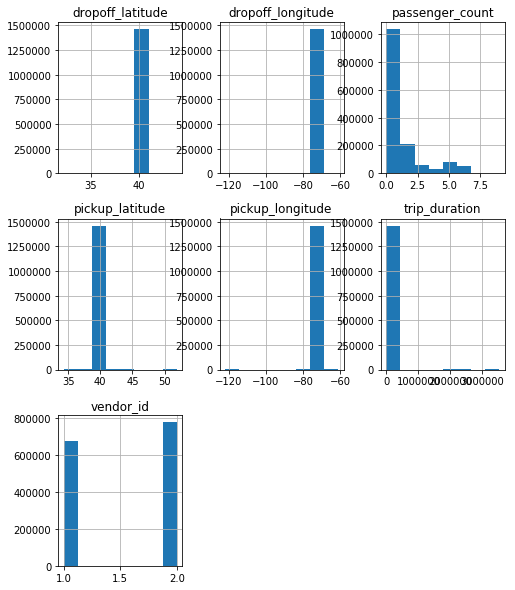

In [102]:
taxi.hist(figsize=(8,10), bins=8)

In [103]:
taxi.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [104]:
taxi.trip_duration.max(), taxi.trip_duration.min()

(3526282, 1)

In [105]:
print('max hours: ' , 3526282/60/60)

max hours:  979.5227777777778


Check for any trips longer than 10 h

In [106]:
taxi[taxi.trip_duration > 36000]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197
4336,id3632390,2,2016-06-08 08:54:33,2016-06-09 07:58:09,5,-73.980560,40.742466,-73.984718,40.748611,N,83016
5104,id3354426,2,2016-05-05 15:18:41,2016-05-06 15:11:07,1,-73.989037,40.773514,-73.980682,40.781521,N,85946
5778,id0773526,2,2016-04-02 14:58:45,2016-04-03 14:19:55,6,-73.987991,40.761341,-74.002922,40.756279,N,84070
6132,id3617210,2,2016-03-15 17:51:32,2016-03-16 17:18:04,1,-73.965607,40.765781,-73.972649,40.753418,N,84392
6513,id0067152,2,2016-02-27 21:04:05,2016-02-28 21:03:22,5,-73.993744,40.727444,-74.001335,40.729244,N,86357


There are > 2000 rows with trip duration longer than 10h; will drop as outliers (initially they were kept in the df and when running the model, clustering created 2 clusters with long trip durations and there were only 2-3 values in each cluster, so clearly these values are not helping the model)

In [107]:
taxi.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [108]:
taxi.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

Might drop the 2 columns above as they are not significant for the clustering, along with the id column

### Visualize the Data to Gain Insights

#### Exploring longitude & latitude

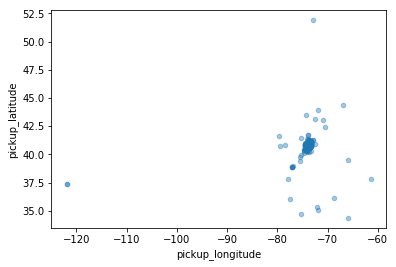

In [109]:
taxi.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4)

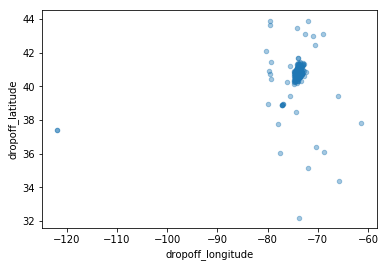

In [110]:
taxi.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', alpha=0.4)

Remove far away destinations to get more clarity on the data for trips that originated & terminated within New York

In [111]:
taxi.pickup_latitude.min(), taxi.pickup_latitude.max()

(34.359695434570305, 51.88108444213867)

In [112]:
taxi.pickup_longitude.min(), taxi.pickup_longitude.max()

(-121.93334197998048, -61.33552932739258)

The area of NYC we will focus is: latitude between 40.6921 and 40.8730, and longitude between -74.0753 and -73.8116

In [113]:
taxi_coordinates = taxi[(taxi.pickup_latitude > 40.6921) & (taxi.pickup_latitude < 40.8730) &
                        (taxi.pickup_longitude > -74.0753) & (taxi.pickup_longitude < -73.8116) &
                       (taxi.dropoff_latitude > 40.6921) & (taxi.dropoff_latitude < 40.8730) &
                        (taxi.dropoff_longitude > -74.0753) & (taxi.dropoff_longitude < -73.8116)]

Also drop the rows with trip duration > 10h as outliers

In [114]:
taxi_coordinates = taxi_coordinates[taxi_coordinates.trip_duration < 36000]

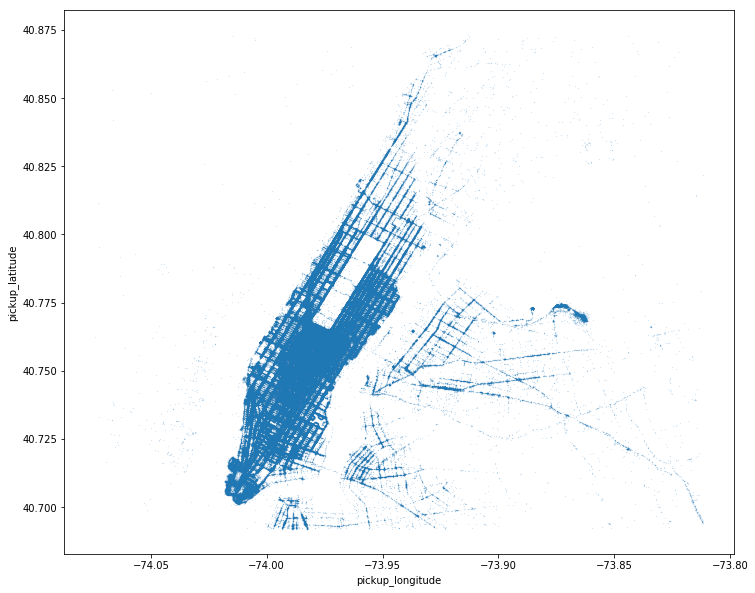

In [115]:
taxi_coordinates.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4, 
                      figsize=(12,10), s = 0.03)

In [116]:
map_= plt.imread('../NYC.png')

In [117]:
# taxi_coordinates.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4,
#           label='pickup', figsize=(12,10), s = 0.03, c='trip_duration', cmap=plt.get_cmap('Dark2'))

# plt.imshow(map_, extent=[-74.0753, -73.8116, 40.6921, 40.8730], alpha=0.5)
# plt.ylabel("Latitude", fontsize=14)
# plt.xlabel("Longitude", fontsize=14)
# plt.legend()
# plt.show()

We can use this information to cluster NYC based on the taxi pickup & dropoff locations and then use this information for further clustering

### K-means clustering for neighborhoods

In [118]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=8, random_state=8)
neighborhood_clusters = kmeans.fit(taxi_coordinates[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])

In [119]:
unique, counts = np.unique(neighborhood_clusters.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([ 40825, 236143, 236828, 273507,  59651,  35213, 244147, 233301]))

In [120]:
taxi_coordinates['labels_neighborhood'] = neighborhood_clusters.labels_

In [121]:
taxi_coordinates.labels_neighborhood.value_counts()

3    273507
6    244147
2    236828
1    236143
7    233301
4     59651
0     40825
5     35213
Name: labels, dtype: int64

In [122]:
taxi_coordinates.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,labels
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,3
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2


In [123]:
# Plot results !!!??

### Further cleaning of the data for 2nd clustering

Drop id, store_and_fwd_flag & vendor_id columns as they are not significant for the clustering, and drop all latitude & longitude information as it's now represented by the cluster information

In [124]:
taxi_coordinates.drop(['id', 'store_and_fwd_flag', 'vendor_id', 'pickup_longitude', 'pickup_latitude',
               'dropoff_longitude', 'dropoff_latitude'], inplace=True, axis=1)

In [125]:
taxi_coordinates.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_duration,labels
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,455,7
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,663,1
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,2124,3
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,429,1
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,435,2


Convert pick up and drop off dates to datetime

In [126]:
taxi_coordinates.pickup_datetime = pd.to_datetime(taxi_coordinates.pickup_datetime)
taxi_coordinates.dropoff_datetime = pd.to_datetime(taxi_coordinates.dropoff_datetime)

In [127]:
taxi_coordinates.dtypes

pickup_datetime     datetime64[ns]
dropoff_datetime    datetime64[ns]
passenger_count              int64
trip_duration                int64
labels                       int32
dtype: object

Feature engineering on datetime

In [128]:
taxi_coordinates['pickup_hour'] = taxi_coordinates.pickup_datetime.dt.hour
taxi_coordinates['pickup_day'] = taxi_coordinates.pickup_datetime.dt.day_name()
taxi_coordinates['dropoff_hour'] = taxi_coordinates.dropoff_datetime.dt.hour
taxi_coordinates['dropoff_day'] = taxi_coordinates.dropoff_datetime.dt.day_name()

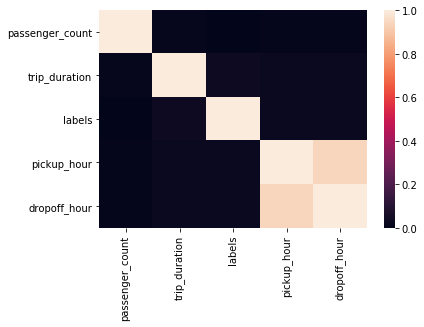

In [129]:
sns.heatmap(taxi_coordinates.corr())

Will drop all dropoff time information as it's highly correlated to the pickup time and moreover we already have a column with trip duration; drop pick up datetime as well since we now have the hour & day columns

In [130]:
taxi_drop = taxi_coordinates.copy()
taxi_drop.drop(['dropoff_datetime', 'dropoff_hour', 'dropoff_day', 'pickup_datetime'], inplace=True, axis=1)

Check the pick up hour & day values

In [131]:
taxi_drop.pickup_day.value_counts()

Friday       208817
Saturday     206015
Thursday     204425
Wednesday    197131
Tuesday      190042
Sunday       179389
Monday       173796
Name: pickup_day, dtype: int64

In [132]:
taxi_drop.pickup_hour.value_counts()

18    85676
19    85205
20    78157
21    77630
22    73361
17    71809
14    69569
12    68688
13    67582
15    67109
11    65564
9     65199
8     64186
10    63037
23    62524
16    59892
7     52471
0     47154
1     34506
6     30168
2     25183
3     18682
4     13619
5     12644
Name: pickup_hour, dtype: int64

Do one hot encoding on day field to transfor the categorical variable

In [133]:
taxi_days = pd.get_dummies(data=taxi_drop, columns=['pickup_day'])

In [134]:
principalDf = taxi_days.copy()

### PCA

???

In [135]:
# from sklearn.decomposition import PCA 

# pca = PCA(n_components=4) 
# principalComponents = pca.fit_transform(taxi_days) 
# principalDf = pd.DataFrame(data = principalComponents ,columns = ['pc1', 'pc2', 'pc3', 'pc4']) 
# principalDf.head()

### K-Means Clustering

???

In [136]:
kmeans = KMeans(n_clusters=5)
taxi_clusters = kmeans.fit(principalDf)

In [137]:
unique, counts = np.unique(taxi_clusters.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4], dtype=int32),
 array([620603, 220990,  46325,     40, 471657]))

In [143]:
taxi_coordinates['labels_clusters'] = taxi_clusters.labels_

In [144]:
taxi_coordinates.labels_clusters.value_counts()

0    620603
4    471657
1    220990
2     46325
3        40
Name: labels_clusters, dtype: int64

In [151]:
plt.scatter(x=taxi_coordinates["passenger_count"], y=taxi_coordinates["trip_duration"], 
            c=taxi_coordinates["labels_clusters"])

TypeError: boxplot() got an unexpected keyword argument 'y'

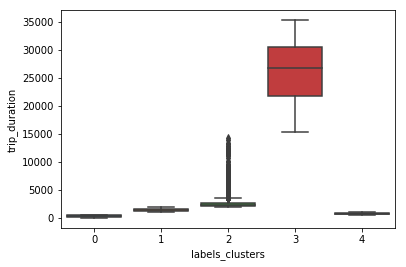

In [156]:
sns.boxplot(x="labels_clusters", y="trip_duration", data=taxi_coordinates)


In [146]:
pd.crosstab(taxi_coordinates.pickup_hour, taxi_coordinates.labels_clusters)

labels_clusters,0,1,2,3,4
pickup_hour,,,,,
0,22999,6729,920,0,16506
1,17673,4442,504,0,11887
2,13394,2984,245,0,8560
3,9976,2245,173,0,6288
4,7304,1795,144,0,4376
5,8054,1285,68,0,3237
6,19989,2173,174,0,7832
7,27967,6068,1166,0,17270
8,28737,10893,2548,0,22008


In [147]:
taxi_group = taxi_coordinates.groupby('pickup_day').sum() 

In [148]:
taxi_group.head()

,passenger_count,trip_duration,labels,pickup_hour,dropoff_hour,labels_clusters
pickup_day,,,,,,
Friday,346432,163998977,766506,2859496,2842438,345010
Monday,283565,125402734,656008,2431333,2443166,271949
Saturday,356049,147049861,744062,2725131,2705286,330829
Sunday,308037,121392592,656542,2187388,2200231,271208
Thursday,334585,166512913,761308,2877557,2874362,341909


In [149]:
pd.crosstab(taxi_group.pickup_day, taxi_days.labels_clusters)

AttributeError: 'DataFrame' object has no attribute 'pickup_day'

### Hierarchical clustering

### DBscan

### Gausian mixture model